In [1]:
%%capture

import import_ipynb
from DME import *

## Functions

In [ ]:
import plotly
import plotly.graph_objects as go
import plotly.io


def node(label, x, y):
    return {"label": label, "x": x/100, "y": y/100}


def link(no, source, target):
    return {"no": no, "source": source, "target": target}


def diff_link(n1, n0, source, target):
    return {"n1": n1, "n0": n0, "source": source, "target": target}


def get_sankey_nodes(nodes, **kwargs):
    """Returns a plotly.graph_objects.sankey.Node object using dictionary nodes written in the form:
    - "label" (reference name of the node and label to be used)
    - "x" (x position of the node)
    - "y" (y position of the node)"""
    label = [n["label"] for n in nodes]
    x = [n["x"] for n in nodes]
    y = [n["y"] for n in nodes]

    return go.sankey.Node(label=label, x=x, y=y, **kwargs)

def get_sankey_links(links, nodes, stream_dict, **kwargs):
    node_label = [n["label"] for n in nodes]
    source = [node_label.index(l["source"]) for l in links]
    target = [node_label.index(l["target"]) for l in links]

    value, label = [], []

    for l in links:
        if "no" in l:
            n = l["no"]
            if n not in stream_dict:
                raise ValueError(f"Missing stream {n}")
            v = stream_dict[n]
            label.append(n)
        else:
            n1, n0 = l["n1"], l["n0"]
            if n1 not in stream_dict or n0 not in stream_dict:
                raise ValueError(f"Missing stream {n1} or {n0}")
            v = stream_dict[n1] - stream_dict[n0]
            label.append(f"{n1} - {n0}")
        value.append(v)
    
    return go.sankey.Link(label=label, source=source, target=target, value=value, **kwargs)

def get_sankey_figure(nodes, links, stream_dict):
    layout = go.Layout(
        autosize=False,
        width=1200,
        height=800,
        title_text="<b>Energy Flow</b><br><span style='font-size:smaller'>Units in <span style='font-family:monospace'>W</span></span>",
        font_size=10,
    )

    fig = go.Figure(
        go.Sankey(
            arrangement="freeform",
            node=get_sankey_nodes(nodes, hovertemplate='%{label}'),
            link=get_sankey_links(links, nodes, stream_dict),
            valuesuffix=" kW",
        )
    )

    fig.update_layout(layout)
    return fig
    

# Sankey Diagram


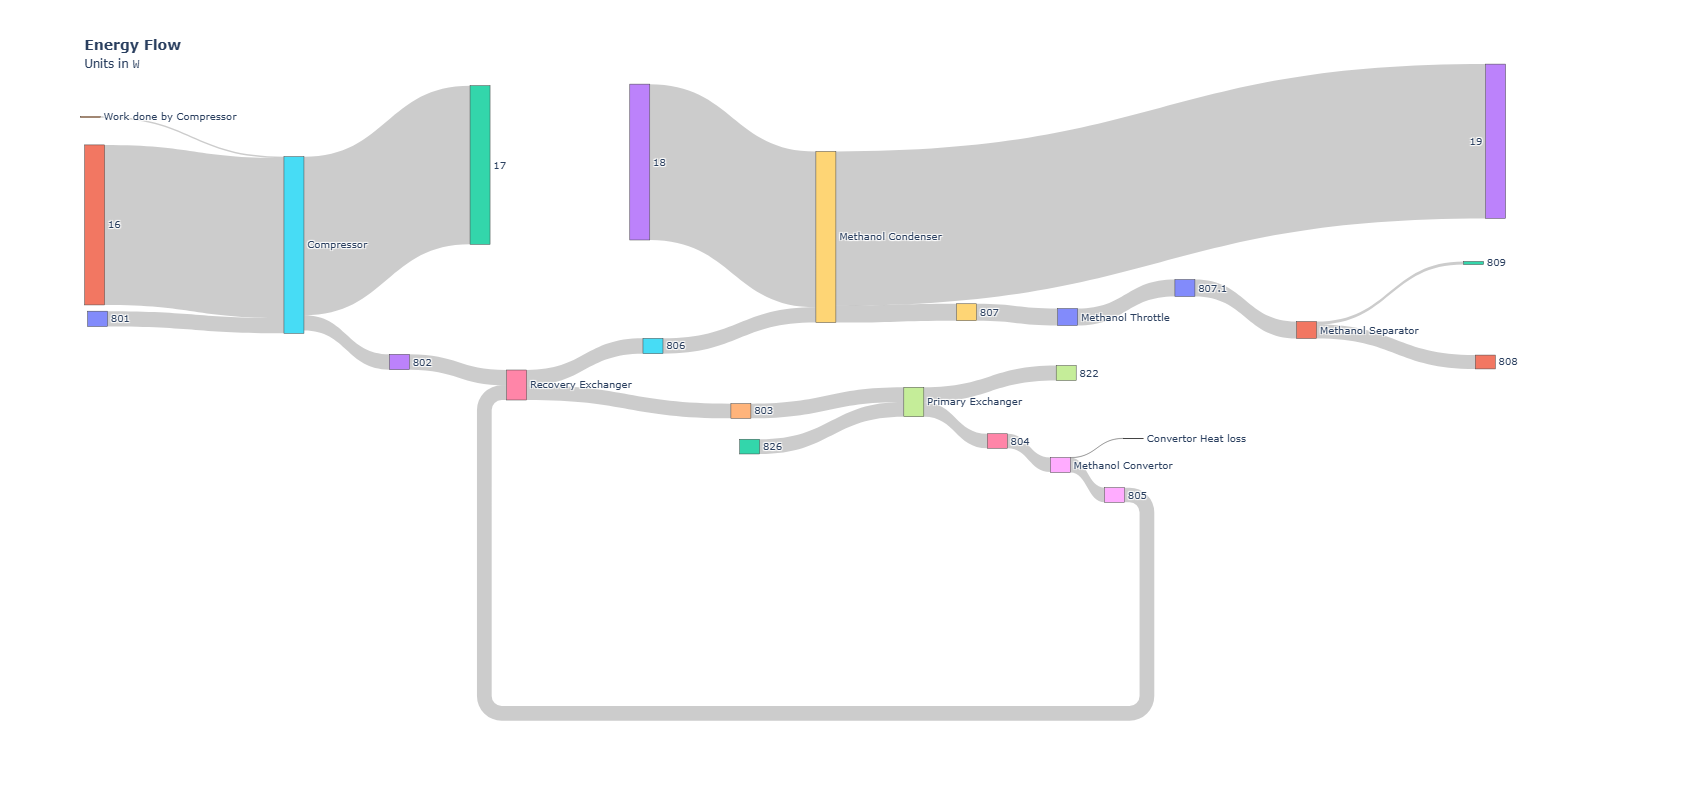

In [30]:
S = {
    "801 Q": 217.11,
    "802 Q": 216.95,
    "803 Q": 209.11,
    "804 Q": 206.08,
    "805 Q": 209.58,
    "806 Q": 217.42,
    "807 Q": 239.99,
    "807.1 Q": 239.99,
    "808 Q": 196.68,
    "809 Q": 43.31,
    "822 Q": 212.34,
    "826 Q": 209.32,
    "16 Q": 2275.76,
    "17 Q": 2256.14,
    "18 Q": 2216.63,
    "19 Q": 2194.06,
    "Compressor Q": 19.79,
    "Convertor Q": 3.5, 
}

# OPTIMIZED NODE POSITIONS
nodes = [
    # Input streams (left side)
    node("801", 0, 20),           # Input to compressor
    node("16", 0, 40),            # Major input to compressor
    node("826", 0, 60),           # Input to primary exchanger
    node("18", 0, 80),            # Input to condenser
    
    # Energy inputs
    node("Work done by Compressor", 5, 10),  # Compressor work input
    
    # Equipment nodes (positioned in process flow order)
    node("Compressor", 15, 30),              # First equipment
    node("Recovery Exchanger", 35, 50),      # Second equipment  
    node("Primary Exchanger", 55, 40),       # Third equipment
    node("Methanol Convertor", 75, 60),      # Fourth equipment
    node("Methanol Condenser", 75, 20),      # Fifth equipment (parallel)
    node("Methanol Throttle", 85, 30),       # Sixth equipment
    node("Methanol Separator", 95, 40),      # Final equipment
    
    # Intermediate streams (positioned to minimize crossings)
    node("17", 25, 15),           # Compressor output
    node("802", 25, 45),          # Compressor to recovery exchanger
    node("803", 45, 65),          # Recovery exchanger output
    node("806", 45, 35),          # Recovery exchanger to condenser
    node("804", 65, 55),          # Primary exchanger output
    node("822", 65, 25),          # Primary exchanger output
    node("805", 85, 75),          # Convertor output (recycle)
    node("807", 85, 15),          # Condenser output
    node("807.1", 95, 25),        # Throttle output
    
    # Output streams (right side)
    node("808", 100, 50),         # Separator output L
    node("809", 100, 30),         # Separator output G
    node("19", 100, 10),          # Condenser output 
    
    # Energy outputs
    node("Convertor Heat loss", 85, 85),     # Heat loss from convertor
]

# Links remain the same
links = [
    link("801 Q", "801", "Compressor"),
    link("Compressor Q", "Work done by Compressor", "Compressor"),
    link("16 Q", "16", "Compressor"),
    link("17 Q", "Compressor", "17"),
    link("802 Q", "Compressor", "802"),
    #END OF COMPRESSOR SECTION
    link("802 Q", "802", "Recovery Exchanger"),
    link("805 Q", "805", "Recovery Exchanger"),
    link("803 Q", "Recovery Exchanger", "803"),
    link("806 Q", "Recovery Exchanger", "806"),
    #END OF RECOVERY HEAT EXCHANGER SECTION
    link("803 Q", "803", "Primary Exchanger"),
    link("826 Q", "826", "Primary Exchanger"),
    link("804 Q", "Primary Exchanger", "804"),
    link("822 Q", "Primary Exchanger", "822"),
    #END OF PRIMARY HEAT EXCHANGER SECTION
    link("804 Q", "804", "Methanol Convertor"),
    link("805 Q", "Methanol Convertor", "805"),
    link("Convertor Q", "Methanol Convertor", "Convertor Heat loss"),
    #END OF METHANOL CONVERTOR
    link("18 Q", "18", "Methanol Condenser"),
    link("806 Q", "806", "Methanol Condenser"),
    link("19 Q", "Methanol Condenser", "19"),
    link("807 Q", "Methanol Condenser", "807"),
    #END OF METHANOL CONDENSER
    link("807 Q", "807", "Methanol Throttle"),
    link("807.1 Q", "Methanol Throttle", "807.1"),
    #END OF METHANOL THROTTLE
    link("807.1 Q", "807.1","Methanol Separator"),
    link("808 Q", "Methanol Separator", "808"),
    link("809 Q", "Methanol Separator", "809"),
]

fig = get_sankey_figure(nodes, links, S)

plotly.io.write_json(fig, 'chart.json')

fig.show()

In [31]:
print(nodes)

[{'label': '801', 'x': 0.0, 'y': 0.2}, {'label': '16', 'x': 0.0, 'y': 0.4}, {'label': '826', 'x': 0.0, 'y': 0.6}, {'label': '18', 'x': 0.0, 'y': 0.8}, {'label': 'Work done by Compressor', 'x': 0.05, 'y': 0.1}, {'label': 'Compressor', 'x': 0.15, 'y': 0.3}, {'label': 'Recovery Exchanger', 'x': 0.35, 'y': 0.5}, {'label': 'Primary Exchanger', 'x': 0.55, 'y': 0.4}, {'label': 'Methanol Convertor', 'x': 0.75, 'y': 0.6}, {'label': 'Methanol Condenser', 'x': 0.75, 'y': 0.2}, {'label': 'Methanol Throttle', 'x': 0.85, 'y': 0.3}, {'label': 'Methanol Separator', 'x': 0.95, 'y': 0.4}, {'label': '17', 'x': 0.25, 'y': 0.15}, {'label': '802', 'x': 0.25, 'y': 0.45}, {'label': '803', 'x': 0.45, 'y': 0.65}, {'label': '806', 'x': 0.45, 'y': 0.35}, {'label': '804', 'x': 0.65, 'y': 0.55}, {'label': '822', 'x': 0.65, 'y': 0.25}, {'label': '805', 'x': 0.85, 'y': 0.75}, {'label': '807', 'x': 0.85, 'y': 0.15}, {'label': '807.1', 'x': 0.95, 'y': 0.25}, {'label': '808', 'x': 1.0, 'y': 0.5}, {'label': '809', 'x': 1

In [32]:
print(get_sankey_nodes(nodes, hovertemplate="%{x}"))

sankey.Node({
    'hovertemplate': '%{x}',
    'label': [801, 16, 826, 18, Work done by Compressor, Compressor, Recovery
              Exchanger, Primary Exchanger, Methanol Convertor, Methanol Condenser,
              Methanol Throttle, Methanol Separator, 17, 802, 803, 806, 804, 822,
              805, 807, 807.1, 808, 809, 19, Convertor Heat loss],
    'x': [0.0, 0.0, 0.0, 0.0, 0.05, 0.15, 0.35, 0.55, 0.75, 0.75, 0.85, 0.95,
          0.25, 0.25, 0.45, 0.45, 0.65, 0.65, 0.85, 0.85, 0.95, 1.0, 1.0, 1.0,
          0.85],
    'y': [0.2, 0.4, 0.6, 0.8, 0.1, 0.3, 0.5, 0.4, 0.6, 0.2, 0.3, 0.4, 0.15, 0.45,
          0.65, 0.35, 0.55, 0.25, 0.75, 0.15, 0.25, 0.5, 0.3, 0.1, 0.85]
})
